<a href="https://colab.research.google.com/github/guiraposo/ML4Gravity/blob/main/ML4Waveforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waveform generation and detetection

Notebook based on the [MachineLearningForStrongGravity](https://github.com/raimonluna/) course given by Raimon Luna.

<br>

### In this notebook, we will see:

1. How to reduce the dimensionality of data by finding an appropriate basis of vectors.
2. How autoencoders "compress" the data by automatically identifying the governing parameters.
3. How we can use GANs to generate samples from the same distribution as the training data.<br>Original paper:<br>

 - Felipe F. Freitas, Carlos A. R. Herdeiro, António P. Morais, António Onofre, Roman Pasechnik, Eugen Radu, Nicolas Sanchis-Gual, Rui Santos, <i>Generating gravitational waveform libraries of exotic compact binaries with deep learning</i>, 2022. https://arxiv.org/abs/2203.01267

<br>

In [1]:
# Import relevant libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

# Auxiliary functions and Definitions:

In [10]:
def showcase(dataset1, dataset2 = None, Nrow = 2, Ncol = 3):
    fig, ax = plt.subplots(Nrow, Ncol,figsize = (8, 4))
    font = {'size'   : 10}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, 64, dtype = np.float32)

    if dataset2 is not None:
        entry = 0
        for i in range(Nrow):
            for j in range(Ncol):
                ax[i,j].plot(x, dataset1[entry, :], 'b', label = 'Data')
                ax[i,j].plot(x, dataset2[entry, :], 'r--', label = 'Approx')
                ax[i,j].legend(loc = 'upper left')
                entry += 1
    else:
        entry = 0
        for i in range(Nrow):
            for j in range(Ncol):
                ax[i,j].plot(x, dataset1[entry, :], 'b')
                entry += 1


In [11]:
def split_data(data):
    return train_test_split(data, test_size=0.25, random_state=42)

# Synthetic Waveforms:

Let us start by generating a dataset with some toy waveforms. We choose a generator of the following type:

$$\psi = \sin(2 \pi k x)\, e^{-8x^2}, $$

representing a sinusoidal function with wave number $k$, modulated by a gaussian profile. For simplicity we shall consider only one parameter ($k$), but in other sections we shall try to extend this to additional parameters.

## Generating Waveforms (1 parameter)

In [14]:
# Generating the dataset of synthetic waveforms
x       = np.linspace(-1, 1, 64, dtype = np.float32)
randoms = 5*np.random.rand(100)
data_1p    = np.array([np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 ) for k in randoms])

## Two parameter waveforms

Let us increase the dimensionality of our model by considering a modification to the previous toy model:
$$\psi = \sin(2 \pi k_1 x)\, e^{-k_2x^2}, $$
where $k_1$ and $k_2$ are two free parameters.

In [15]:
# Generating the dataset of synthetic waveforms
randoms_k1 = 5*np.random.rand(100)
randoms_k2 = 2*np.random.rand(100)
data_2p    = np.array([np.sin(2 * k_1 * np.pi * x) * np.exp(- 8* k_2 * x**2 ) for k_1, k_2 in zip(randoms_k1, randoms_k2)])

## Train-test Splitting

In [16]:
# Standard splitting using sklearn
data_train_1p, data_test_1p = split_data(data_1p)
data_train_2p, data_test_2p = split_data(data_2p)

## Visualization of some examples:

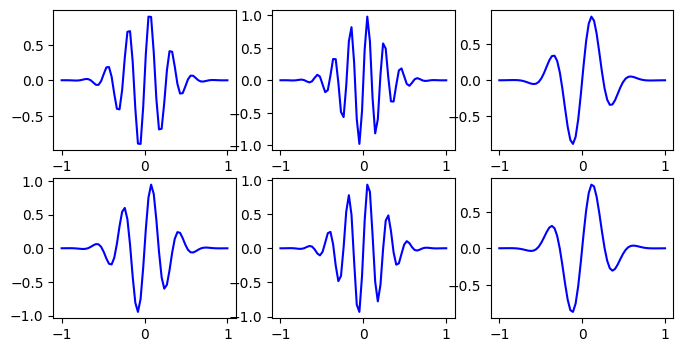

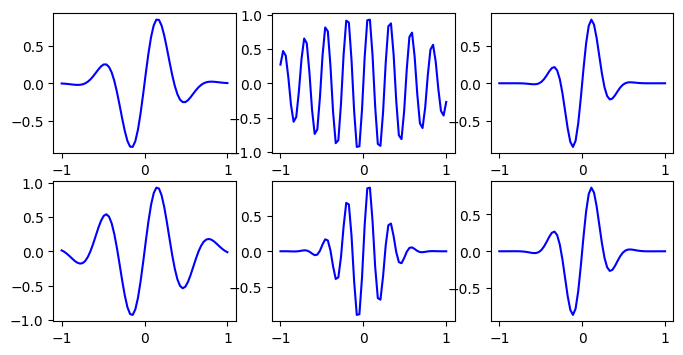

In [17]:
showcase(data_1p)
showcase(data_2p)

# PCA decomposition (1 parameter)

We can start by using principal component analysis to reduce the dimensionality of our problem.

Our goal is to be able to be able to reduce the number of features, but still reproducing the waveform as well as possible.

## Training:

In [18]:
pca = PCA(n_components = 10)
pca.fit(data_train_1p);

## Testing and visualization

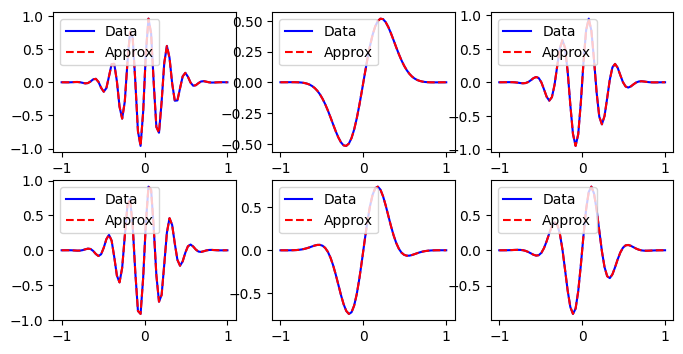

In [19]:
encoded = pca.transform(data_test_1p)
decoded = pca.inverse_transform(encoded)
showcase(data_test_1p, decoded)

As we can see it is clear that 10 principal components model very well the testing set. But how many components do we need? Let us analyse this question in the next section.


## Minimum number of components
To see this more quantitatively we can perform do a more systematic check and look at the cumulative variance of the model.

Let us assume we want to preserve 99% of cumulative variance.

In [20]:
pca = PCA()
pca.fit(data_train_1p);
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

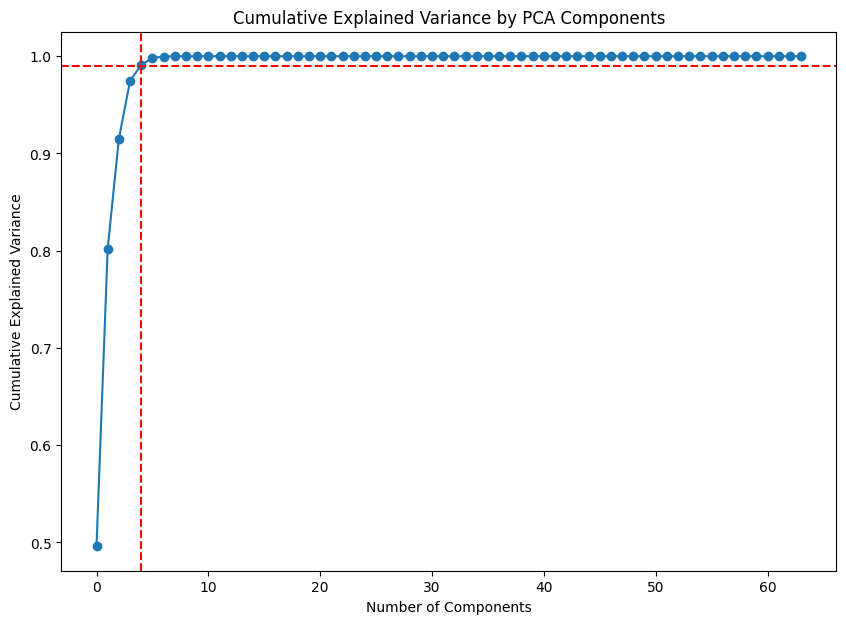

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()

The minimum number of components that we need to include to preserver a minimum of 99% of cumulative variance is 5, but we also see that around $n=6$, it saturates.

## Training with minimum number of components:

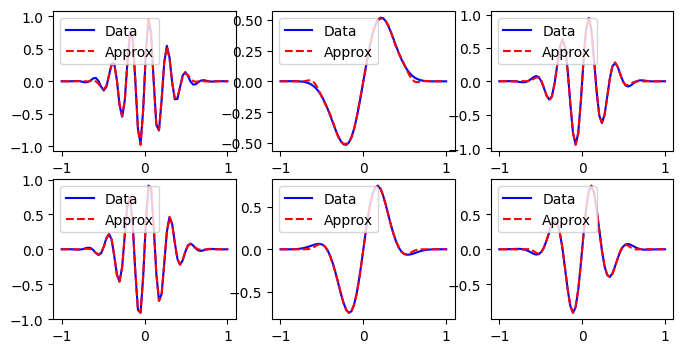

In [22]:
pca = PCA(n_components = 6)
pca.fit(data_train_1p);
encoded = pca.transform(data_test_1p)
decoded = pca.inverse_transform(encoded)
showcase(data_test_1p, decoded)

# PCA decomposition (2 parameter)

Let us repeat the previous analysis but for the case of a 2 parameter model.

## Training:

In [23]:
pca = PCA(n_components = 10)
pca.fit(data_train_2p);

## Testing and visualization

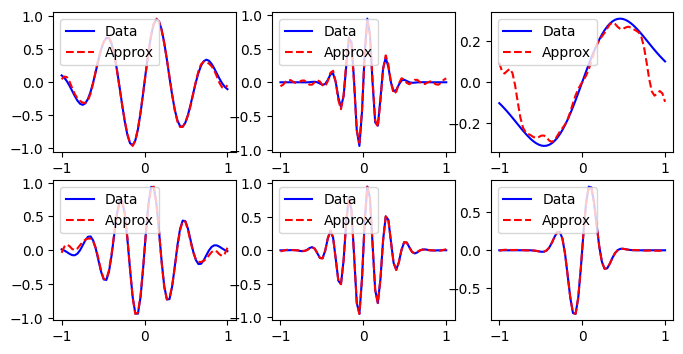

In [24]:
encoded = pca.transform(data_test_2p)
decoded = pca.inverse_transform(encoded)
showcase(data_test_2p, decoded)

As we can see from the visualization above it is clear that 10 principal components model much worse the testing set when compared with the analysis for the 1 parameter model. Let us see what is the minimum number of components that we need for an accurate representation.


## Minimum number of components
To see this more quantitatively we can perform do a more systematic check and look at the cumulative variance of the model.

Let us assume we want to preserve 99% of cumulative variance.

In [25]:
pca = PCA()
pca.fit(data_train_2p);
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

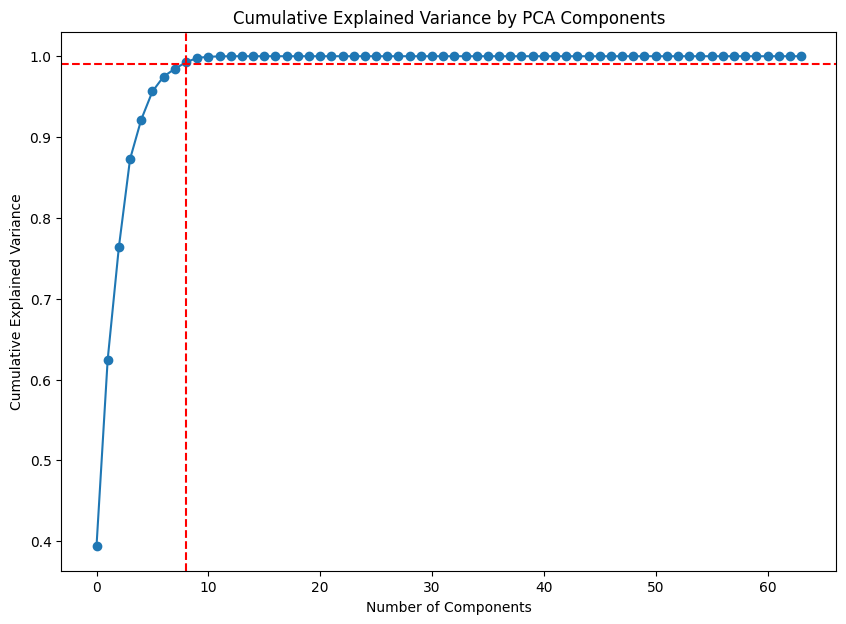

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()

The minimum number of components that we need to include to preserver a minimum of 99% of cumulative variance is 5, but we also see that around $n=6$, it saturates.

## Training with minimum number of components:

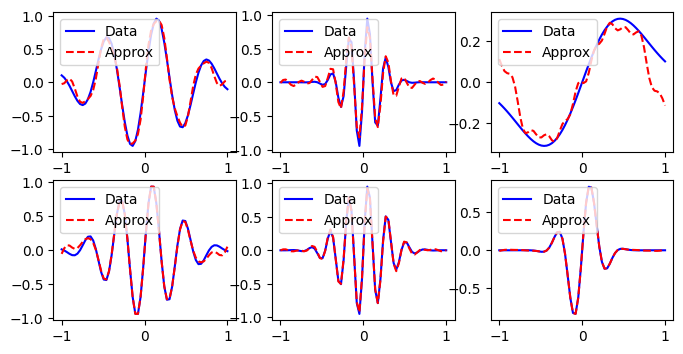

In [28]:
pca = PCA(n_components = 9)
pca.fit(data_train_2p);
encoded = pca.transform(data_test_2p)
decoded = pca.inverse_transform(encoded)
showcase(data_test_2p, decoded)

In some of these cases this is much worse than before. It would be interesting to further explore this.

# Singular Value Decomposition (SVD): 1 parameter model

Here the idea is the same as before, however we are exploring a different method to achieve the dimensionality reduction.

In [29]:
svd = TruncatedSVD(n_components = 6)
svd.fit(data_train_1p);

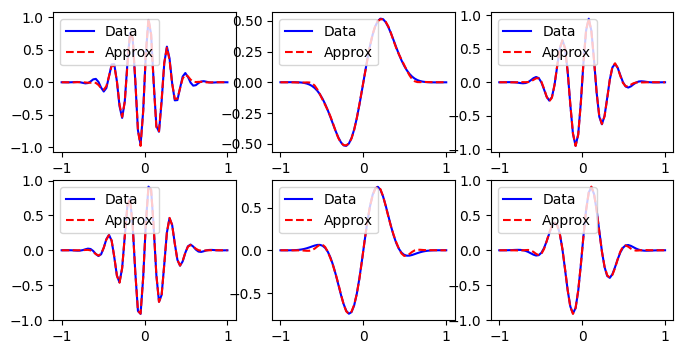

In [30]:
encoded = svd.transform(data_test_1p)
decoded = svd.inverse_transform(encoded)
showcase(data_test_1p, decoded)

In [31]:
svd = TruncatedSVD(n_components=20)
svd.fit(data_train_1p);

explained_variance_ratio = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
print(n_components)

6


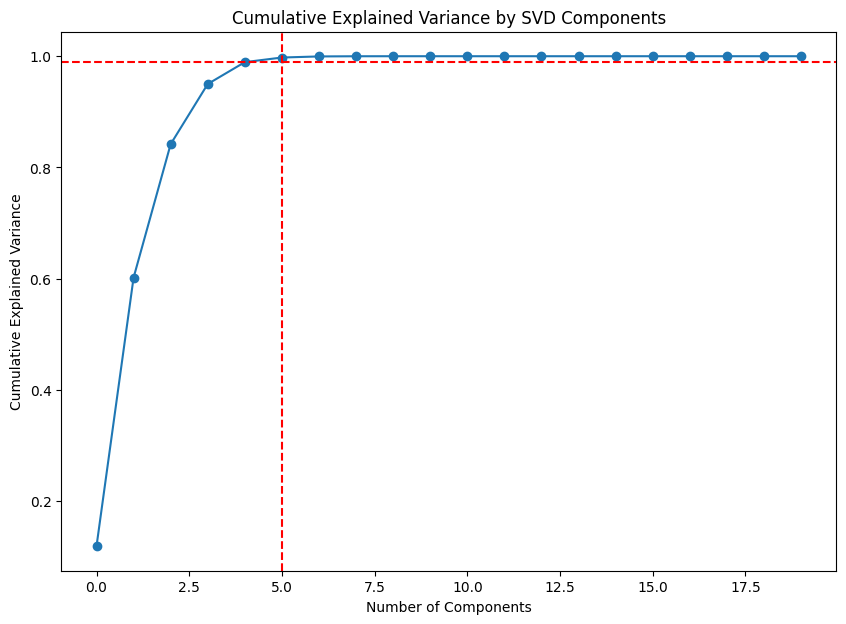

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by SVD Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()

We see that to achieve the same order of cumulative variance we need more or less the same number of components, which in this case is $n≈6$.

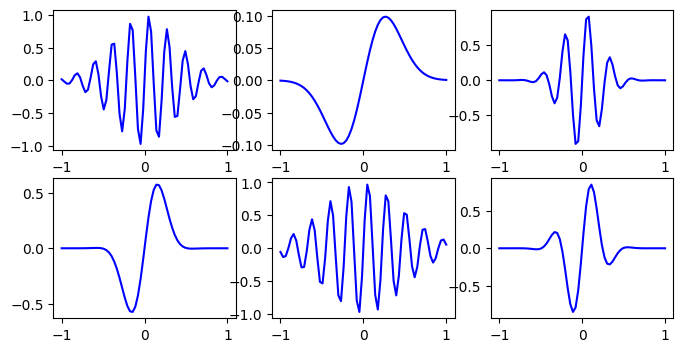

In [9]:
showcase(data)

# Singular Value Decomposition (SVD): 2 parameter model

Same as before. Let us study the case of the two parameter waveforms.

In [48]:
svd = TruncatedSVD(n_components = 12)
svd.fit(data_train_2p);

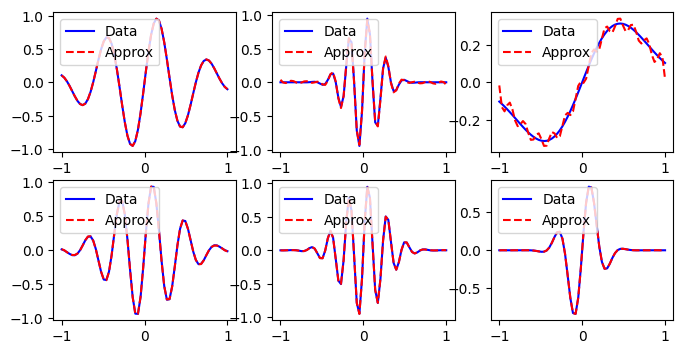

In [49]:
encoded = svd.transform(data_test_2p)
decoded = svd.inverse_transform(encoded)
showcase(data_test_2p, decoded)

In [42]:
svd = TruncatedSVD(n_components=30)
svd.fit(data_train_2p);

explained_variance_ratio = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
threshold = 0.99
n_components = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
print(n_components)

9


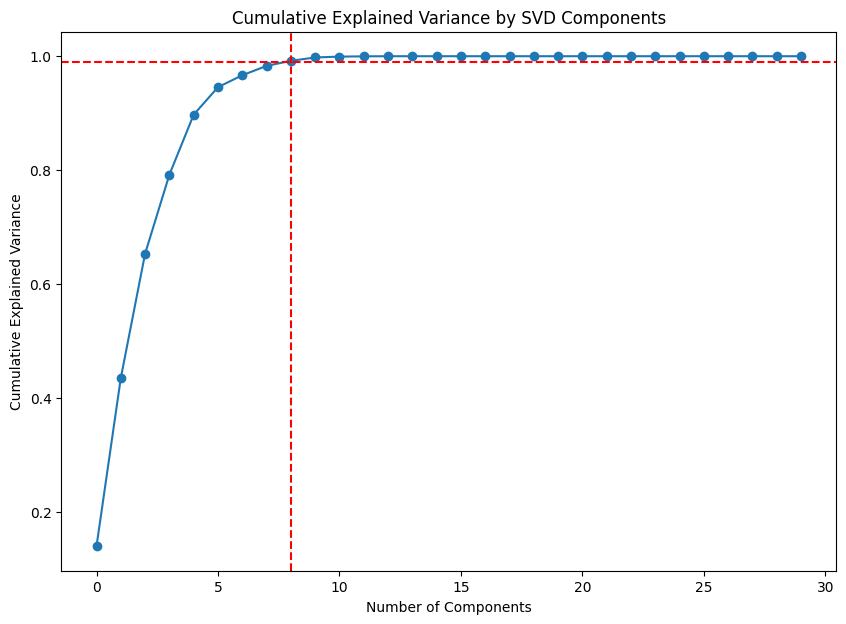

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by SVD Components')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.show()

We see that to achieve the same order of cumulative variance we need more or less the same number of components, which in this case is $n≈9$.

# Generating Waveforms with Autoencoders

In [50]:
wave_size   = 64
num_samples = 1024

batch_size = 64
lr         = 0.00002
beta1      = 0.5
niter      = 25

nz  = 2     # Size of latent vector
nef = 64    # Filter size of encoder
ndf = 64    # Filter size of decoder
nc  = 1     # Output wave channels

In [51]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def show_some_cases(dataset1, dataset2 = None):
    fig, ax = plt.subplots(2,3, figsize = (12, 4));
    font = {'size'   : 10}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, wave_size, dtype = np.float32)
    for i in range(2):
        for j in range(3):
            if dataset2 is not None:
                ax[i,j].plot(x, dataset1[j + 3*i, 0, :], 'b', label = 'Data')
                ax[i,j].plot(x, dataset2[j + 3*i, 0, :], 'r--', label = 'Approx')
                ax[i,j].legend(loc = 'upper left')
            else:
                ax[i,j].plot(x, dataset1[j + 3*i, 0, :], 'b')

# Generating Waveforms with GANs